In [40]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer


Import the ISOT dataset

In [41]:
isot_fake = pd.read_csv('isot_dataset/fake.csv')
isot_true = pd.read_csv('isot_dataset/true.csv')

Check the columns and rename text into statement. This has been done based on the columns in the other dataset.

In [42]:
print(isot_fake.columns)
print(isot_true.columns)

isot_fake.columns = ['title','statement', 'subject', 'date']
isot_true.columns = ['title','statement', 'subject', 'date']

Index(['title', 'text', 'subject', 'date'], dtype='object')
Index(['title', 'text', 'subject', 'date'], dtype='object')


Drop unnecessary columns:

In [43]:
isot_fake = isot_fake.drop(['title', 'subject', 'date'], axis=1)
isot_true = isot_true.drop(['title', 'subject', 'date'], axis=1)

Add a label column to the datasets:

In [44]:
isot_fake['label'] = "False"
isot_true['label'] = "True"

Combine the datasets and shuffle the rows:

In [45]:
isot_combined = pd.concat([isot_fake, isot_true], ignore_index=True)
isot_combined = isot_combined.sample(frac=1, random_state=42).reset_index(drop=True)

print(isot_combined)

                                               statement  label
0      21st Century Wire says Ben Stein, reputable pr...  False
1      WASHINGTON (Reuters) - U.S. President Donald T...   True
2      (Reuters) - Puerto Rico Governor Ricardo Rosse...   True
3      On Monday, Donald Trump once again embarrassed...  False
4      GLASGOW, Scotland (Reuters) - Most U.S. presid...   True
...                                                  ...    ...
44893                                                     False
44894  LONDON/TOKYO (Reuters) - British Prime Ministe...   True
44895  BERLIN (Reuters) - Chancellor Angela Merkel sa...   True
44896  Jesus f*cking Christ our President* is a moron...  False
44897  IF SHE S NOT TOAST NOW THEN WE RE IN BIGGER TR...  False

[44898 rows x 2 columns]


Split the dataset into training, testing and validation sets usigng 80-10-10:

In [46]:
train_data, temp_data = train_test_split(isot_combined, test_size=0.2, random_state=42, stratify=isot_combined['label'])
test_data, valid_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['label'])

Remove whitespace lines:

In [47]:
print(train_data.shape)
print(test_data.shape)
print(valid_data.shape)

(35918, 2)
(4490, 2)
(4490, 2)


In [48]:
isot_train_data = train_data[train_data['statement'].str.strip().astype(bool)]
isot_test_data = test_data[test_data['statement'].str.strip().astype(bool)]
isot_valid_data = valid_data[valid_data['statement'].str.strip().astype(bool)]

Remove duplicate rows if any:

In [49]:
isot_train_data = isot_train_data.drop_duplicates(subset='statement')
isot_test_data = isot_test_data.drop_duplicates(subset='statement')
isot_valid_data = isot_valid_data.drop_duplicates(subset='statement')

The following function is used to clean the text. It converts the text to lowercase and removes URLs and extra spaces:
- The text is lowercased to ensure that the model does not treat the same word with different cases as different words.
- URLs and extra spaces are removed because they do not provide any useful information for the model.

In [50]:
def clean_text(text):
    text = text.lower() # lowercase text
    text = re.sub(r'http\S+|www.\S+', '', text)  # remove URLs
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

Clean the text in the dataset:

In [51]:
isot_train_data['statement'] = isot_train_data['statement'].apply(clean_text)
isot_test_data['statement'] = isot_test_data['statement'].apply(clean_text)
isot_valid_data['statement'] = isot_valid_data['statement'].apply(clean_text)

The following function is used to fix the number format. It replaces commas in numbers ('15,000' -> '15000'):

In [52]:
def fix_number_format(text):
    # Replace commas in numbers ('15,000' -> '15000')
    text = re.sub(r'(\d),(\d)', r'\1\2', text)
    return text

Fix the number format in the dataset:

In [53]:
isot_train_data['statement'] = isot_train_data['statement'].apply(fix_number_format)
isot_test_data['statement'] = isot_test_data['statement'].apply(fix_number_format)
isot_valid_data['statement'] = isot_valid_data['statement'].apply(fix_number_format)

Remove null lines:

In [54]:
isot_train_data = isot_train_data[isot_train_data['statement'].str.strip().astype(bool)]
isot_test_data = isot_test_data[isot_test_data['statement'].str.strip().astype(bool)]
isot_valid_data = isot_valid_data[isot_valid_data['statement'].str.strip().astype(bool)]

Set size:

In [55]:
print('Training Set Size:', isot_train_data.shape[0])
print('Testing Set Size:', isot_test_data.shape[0])
print('Validation Set Size:', isot_valid_data.shape[0])

Training Set Size: 31716
Testing Set Size: 4351
Validation Set Size: 4353


Mean Word Count: ( Average number of words in a statement)

In [56]:
isot_train_data['word_count'] = isot_train_data['statement'].apply(lambda x: len(x.split()))
isot_test_data['word_count'] = isot_test_data['statement'].apply(lambda x: len(x.split()))
isot_valid_data['word_count'] = isot_valid_data['statement'].apply(lambda x: len(x.split()))

print('Mean Word Count in Training Set:', isot_train_data['word_count'].mean())
print('Mean Word Count in Testing Set:', isot_test_data['word_count'].mean())
print('Mean Word Count in Validation Set:', isot_valid_data['word_count'].mean())

Mean Word Count in Training Set: 405.60486820532225
Mean Word Count in Testing Set: 404.44334635715927
Mean Word Count in Validation Set: 405.5646680450264


Median Word Count: (Middle value of the word count)

In [57]:
print('Median Word Count in Training Set:', isot_train_data['word_count'].median())
print('Median Word Count in Testing Set:', isot_test_data['word_count'].median())
print('Median Word Count in Validation Set:', isot_valid_data['word_count'].median())


Median Word Count in Training Set: 368.0
Median Word Count in Testing Set: 363.0
Median Word Count in Validation Set: 367.0


Mode Word Count: (Most frequent word count)

In [58]:
print('Mode Word Count in Training Set:', isot_train_data['word_count'].mode()[0])
print('Mode Word Count in Testing Set:', isot_test_data['word_count'].mode()[0])
print('Mode Word Count in Validation Set:', isot_valid_data['word_count'].mode()[0])

Mode Word Count in Training Set: 403
Mode Word Count in Testing Set: 406
Mode Word Count in Validation Set: 402


Maximum Word Count: (Maximum number of words in a statement)

In [59]:
print('Maximum Word Count in Training Set:', isot_train_data['word_count'].max())
# print(isot_train_data[isot_train_data['word_count'] == isot_train_data['word_count'].max()]['statement'].values[0])
print('Maximum Word Count in Testing Set:', isot_test_data['word_count'].max())
print('Maximum Word Count in Validation Set:', isot_valid_data['word_count'].max())

Maximum Word Count in Training Set: 8135
Maximum Word Count in Testing Set: 5657
Maximum Word Count in Validation Set: 7033


Minimum Word Count: (Minimum number of words in a statement)

In [60]:
print('Minimum Word Count in Training Set:', isot_train_data['word_count'].min())
print(isot_train_data[isot_train_data['word_count'] == isot_train_data['word_count'].min()]['statement'].values[0])
print('Minimum Word Count in Testing Set:', isot_test_data['word_count'].min())
print(isot_test_data[isot_test_data['word_count'] == isot_test_data['word_count'].min()]['statement'].values[0])
print('Minimum Word Count in Validation Set:', isot_valid_data['word_count'].min())
print(isot_valid_data[isot_valid_data['word_count'] == isot_valid_data['word_count'].min()]['statement'].values[0])

Minimum Word Count in Training Set: 1
ouch!
Minimum Word Count in Testing Set: 1
enjoy:
Minimum Word Count in Validation Set: 2
via: gp


Standard deviation of Word Count: (Measure of the amount of variation or dispersion of a set of values)

In [61]:
print('Standard Deviation of Word Count in Training Set:', isot_train_data['word_count'].std())
print('Standard Deviation of Word Count in Testing Set:', isot_test_data['word_count'].std())
print('Standard Deviation of Word Count in Validation Set:', isot_valid_data['word_count'].std())

Standard Deviation of Word Count in Training Set: 322.2137171619187
Standard Deviation of Word Count in Testing Set: 334.4669479349062
Standard Deviation of Word Count in Validation Set: 322.8607756190761


IQR of Word Count: (Measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles)

In [62]:
Q1 = isot_train_data['word_count'].quantile(0.25)
Q3 = isot_train_data['word_count'].quantile(0.75)
print('Interquartile Range of Word Count in Training Set:', Q3 - Q1)

Q1 = isot_test_data['word_count'].quantile(0.25)
Q3 = isot_test_data['word_count'].quantile(0.75)
print('Interquartile Range of Word Count in Testing Set:', Q3 - Q1)

Q1 = isot_valid_data['word_count'].quantile(0.25)
Q3 = isot_valid_data['word_count'].quantile(0.75)
print('Interquartile Range of Word Count in Validation Set:', Q3 - Q1)

Interquartile Range of Word Count in Training Set: 295.0
Interquartile Range of Word Count in Testing Set: 303.0
Interquartile Range of Word Count in Validation Set: 301.0


In [63]:
isot_train_data.to_csv('preprocessed_isot/isot_train.csv', index=False)
isot_test_data.to_csv('preprocessed_isot/isot_test.csv', index=False)
isot_valid_data.to_csv('preprocessed_isot/isot_valid.csv', index=False)

Check the distribution of text length in the training set:

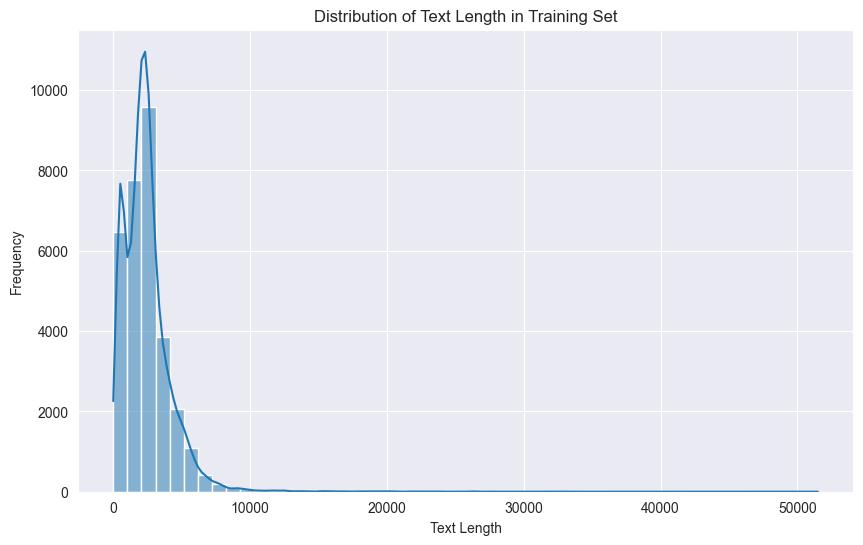

In [64]:
isot_train_data['text_length'] = isot_train_data['statement'].apply(len)
plt.figure(figsize=(10,6))
sns.histplot(isot_train_data['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Length in Training Set')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

Check the distribution of text length in the testing set:

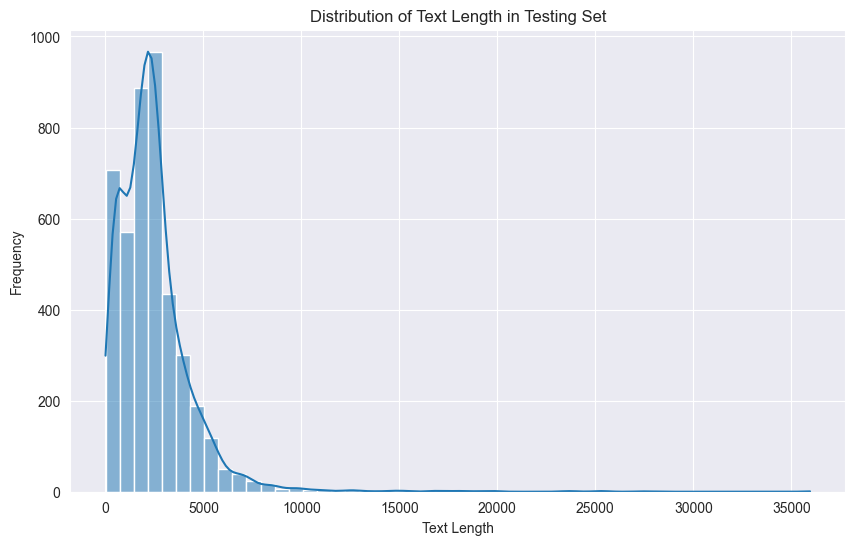

In [65]:
isot_test_data['text_length'] = isot_test_data['statement'].apply(len)
plt.figure(figsize=(10,6))
sns.histplot(isot_test_data['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Length in Testing Set')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

Check the distribution of text length in the validation set:

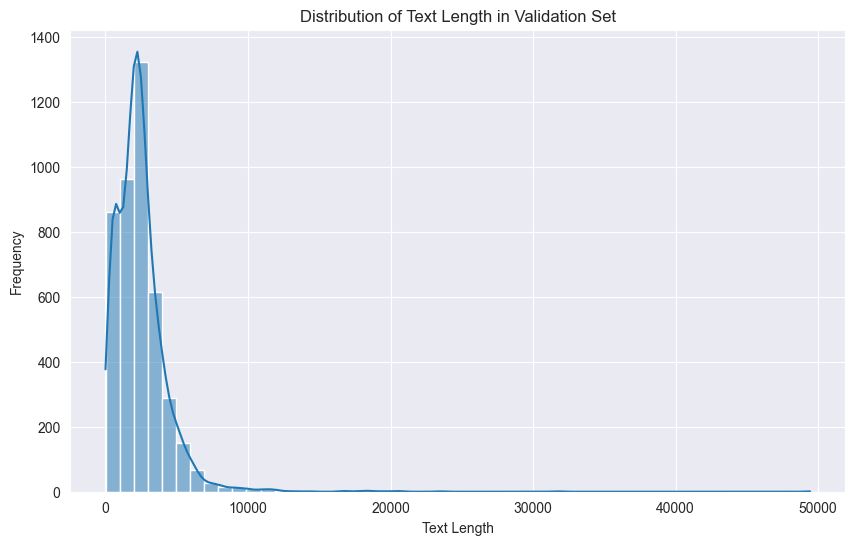

In [66]:
isot_valid_data['text_length'] = isot_valid_data['statement'].apply(len)
plt.figure(figsize=(10,6))
sns.histplot(isot_valid_data['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Length in Validation Set')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

Check the class distribution in the training set:

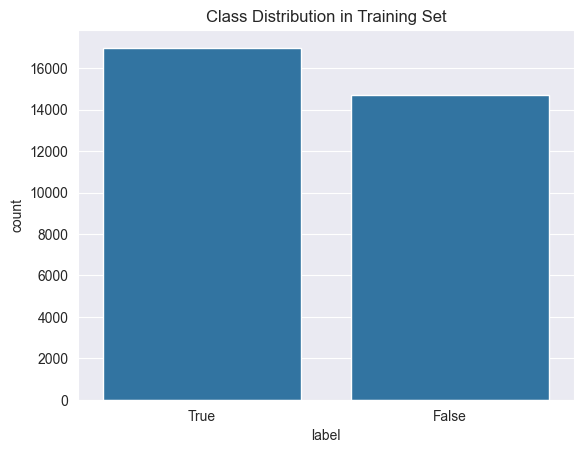

In [67]:
sns.countplot(x='label', data=isot_train_data)
plt.title('Class Distribution in Training Set')
plt.show()

Check the class distribution in the testing set:

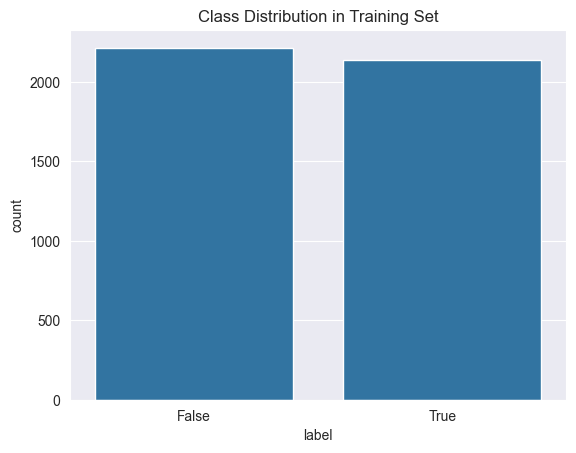

In [68]:
sns.countplot(x='label', data=isot_test_data)
plt.title('Class Distribution in Training Set')
plt.show()

Check the class distribution in the validation set:

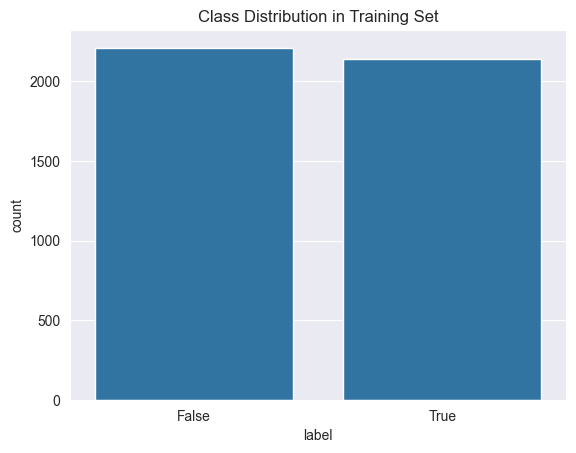

In [69]:
sns.countplot(x='label', data=isot_valid_data)
plt.title('Class Distribution in Training Set')
plt.show()

Check the length of text by class in the training set:

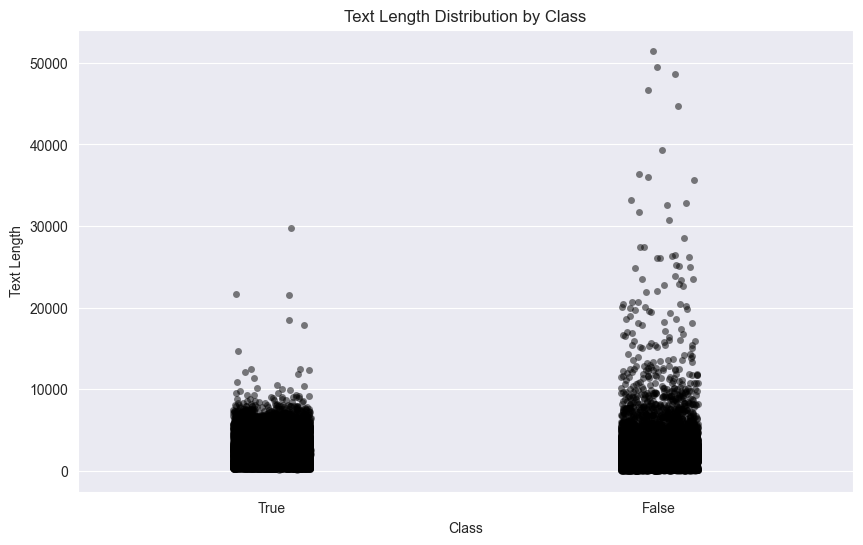

In [70]:
plt.figure(figsize=(10,6))
sns.stripplot(x='label', y='text_length', data=isot_train_data, color='black', alpha=0.5)
plt.title('Text Length Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Text Length')
plt.show()

Check the length of text by class in the testing set:

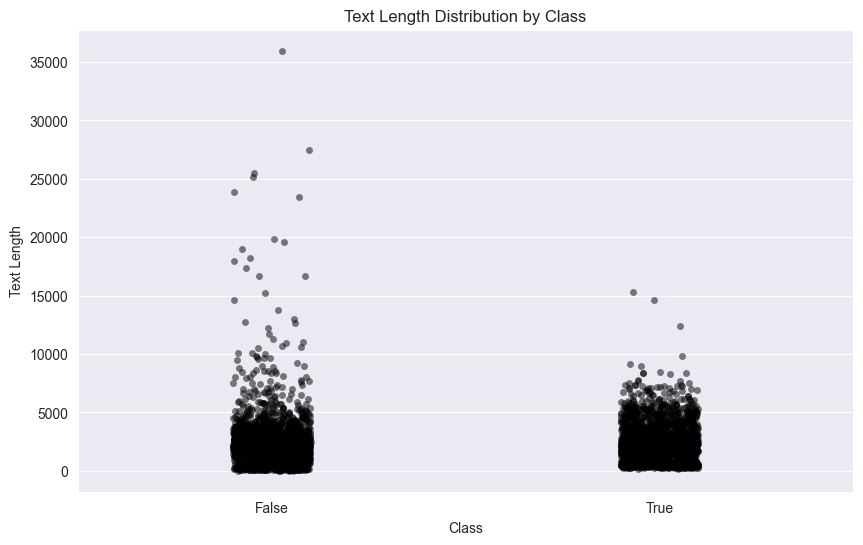

In [71]:
plt.figure(figsize=(10,6))
sns.stripplot(x='label', y='text_length', data=isot_test_data, color='black', alpha=0.5)
plt.title('Text Length Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Text Length')
plt.show()

Check the length of text by class in the validation set:

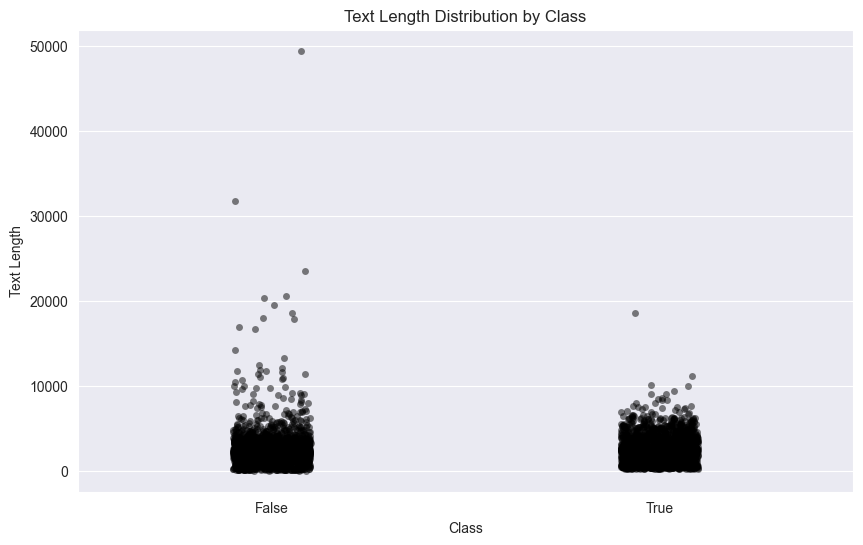

In [72]:
plt.figure(figsize=(10,6))
sns.stripplot(x='label', y='text_length', data=isot_valid_data, color='black', alpha=0.5)
plt.title('Text Length Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Text Length')
plt.show()

Check the word frequency in the training set:

In [73]:
vectorizer = CountVectorizer(stop_words='english', max_features=50, ngram_range=(1, 2))
X = vectorizer.fit_transform(isot_train_data['statement'])

words = vectorizer.get_feature_names_out()
frequencies = X.sum(axis=0).A1
word_freq = dict(zip(words, frequencies))

sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
print(sorted_word_freq)

[('said', 99777), ('trump', 99484), ('president', 40021), ('people', 30006), ('state', 24645), ('reuters', 23279), ('new', 22310), ('donald', 20901), ('government', 20422), ('house', 20352), ('republican', 19718), ('donald trump', 19626), ('states', 19538), ('clinton', 19282), ('obama', 18868), ('year', 17921), ('just', 17493), ('united', 17334), ('told', 16852), ('white', 16271), ('campaign', 16047), ('like', 15727), ('election', 15606), ('party', 15463), ('time', 15006), ('united states', 13824), ('washington', 13646), ('news', 13541), ('country', 13039), ('did', 12017), ('years', 11872), ('security', 11324), ('law', 11136), ('say', 11111), ('white house', 10994), ('american', 10976), ('court', 10975), ('republicans', 10834), ('hillary', 10815), ('national', 10797), ('percent', 10786), ('political', 10745), ('right', 10554), ('make', 10488), ('media', 10280), ('presidential', 10216), ('going', 10182), ('administration', 10064), ('russia', 10042), ('police', 9948)]


Plot the top 10 frequent words in the training set:

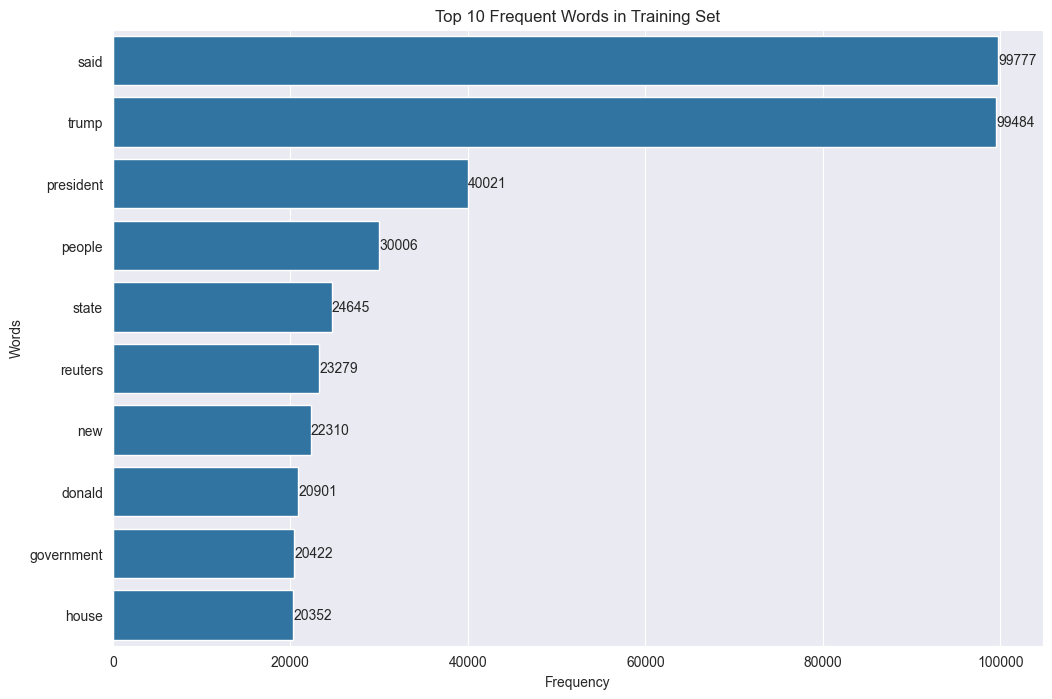

In [74]:
plt.figure(figsize=(12,8))
sns.barplot(x=[item[1] for item in sorted_word_freq[:10]], y=[item[0] for item in sorted_word_freq[:10]])
for index, value in enumerate([item[1] for item in sorted_word_freq[:10]]):
    plt.text(value, index, str(value), va='center')
plt.title('Top 10 Frequent Words in Training Set')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

Check the word frequency in the testing set:


In [75]:
vectorizer = CountVectorizer(stop_words='english', max_features=50, ngram_range=(1, 2))
X = vectorizer.fit_transform(isot_test_data['statement'])

words = vectorizer.get_feature_names_out()
frequencies = X.sum(axis=0).A1
word_freq = dict(zip(words, frequencies))

sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
print(sorted_word_freq)

[('trump', 13436), ('said', 12970), ('president', 5363), ('people', 4017), ('state', 3545), ('new', 2996), ('reuters', 2906), ('donald', 2776), ('obama', 2773), ('house', 2704), ('government', 2701), ('clinton', 2653), ('donald trump', 2609), ('states', 2575), ('year', 2556), ('just', 2428), ('republican', 2428), ('told', 2281), ('united', 2255), ('like', 2233), ('white', 2101), ('election', 2092), ('time', 2065), ('party', 1968), ('news', 1959), ('campaign', 1951), ('united states', 1831), ('washington', 1791), ('country', 1723), ('did', 1632), ('media', 1578), ('security', 1541), ('law', 1532), ('national', 1525), ('years', 1519), ('say', 1516), ('white house', 1501), ('hillary', 1496), ('right', 1489), ('political', 1475), ('american', 1449), ('percent', 1444), ('court', 1439), ('police', 1424), ('make', 1389), ('twitter', 1380), ('going', 1362), ('russia', 1349), ('administration', 1342), ('republicans', 1338)]


Plot the top 10 frequent words in the testing set:

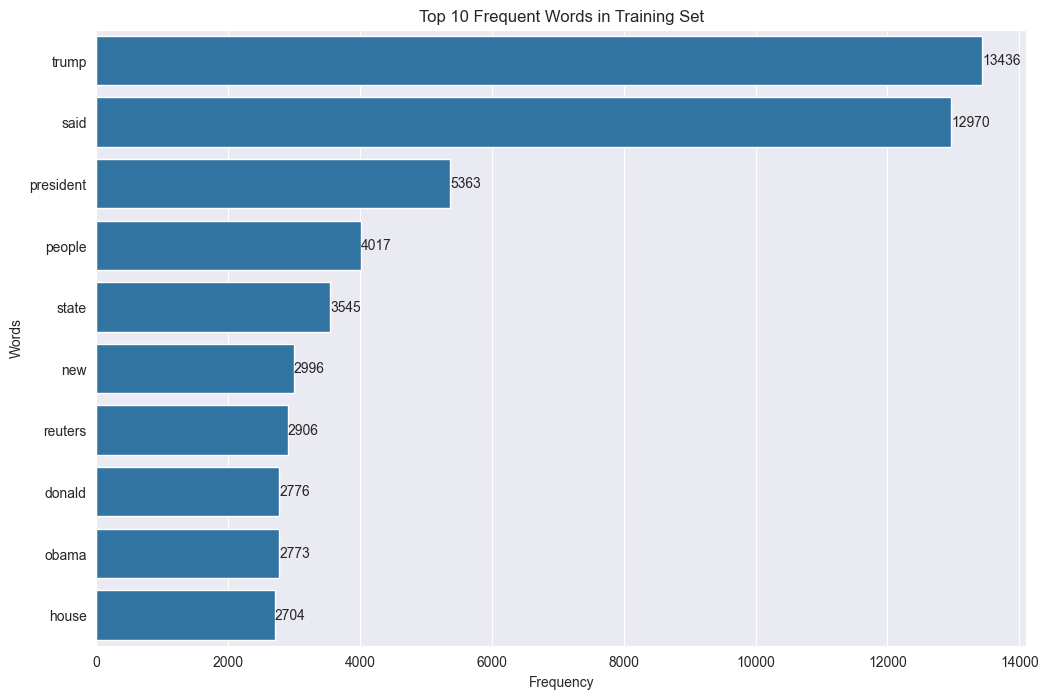

In [76]:
plt.figure(figsize=(12,8))
sns.barplot(x=[item[1] for item in sorted_word_freq[:10]], y=[item[0] for item in sorted_word_freq[:10]])
for index, value in enumerate([item[1] for item in sorted_word_freq[:10]]):
    plt.text(value, index, str(value), va='center')
plt.title('Top 10 Frequent Words in Training Set')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

Check the word frequency in the validation set:


In [77]:
vectorizer = CountVectorizer(stop_words='english', max_features=50, ngram_range=(1, 2))
X = vectorizer.fit_transform(isot_valid_data['statement'])

words = vectorizer.get_feature_names_out()
frequencies = X.sum(axis=0).A1
word_freq = dict(zip(words, frequencies))

sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
print(sorted_word_freq)

[('said', 13242), ('trump', 13128), ('president', 5580), ('people', 3939), ('state', 3482), ('new', 3096), ('clinton', 2922), ('reuters', 2906), ('obama', 2822), ('states', 2791), ('donald', 2777), ('house', 2729), ('donald trump', 2639), ('government', 2628), ('just', 2451), ('republican', 2441), ('united', 2413), ('year', 2397), ('told', 2347), ('white', 2286), ('like', 2216), ('news', 2095), ('campaign', 2086), ('election', 2035), ('time', 1996), ('united states', 1918), ('party', 1911), ('washington', 1835), ('country', 1772), ('did', 1691), ('security', 1678), ('hillary', 1661), ('years', 1640), ('police', 1604), ('national', 1594), ('media', 1588), ('white house', 1571), ('law', 1558), ('american', 1547), ('say', 1520), ('percent', 1501), ('republicans', 1477), ('russia', 1470), ('twitter', 1439), ('court', 1433), ('make', 1427), ('political', 1412), ('administration', 1404), ('according', 1379), ('right', 1356)]


Plot the top 10 frequent words in the validation set:

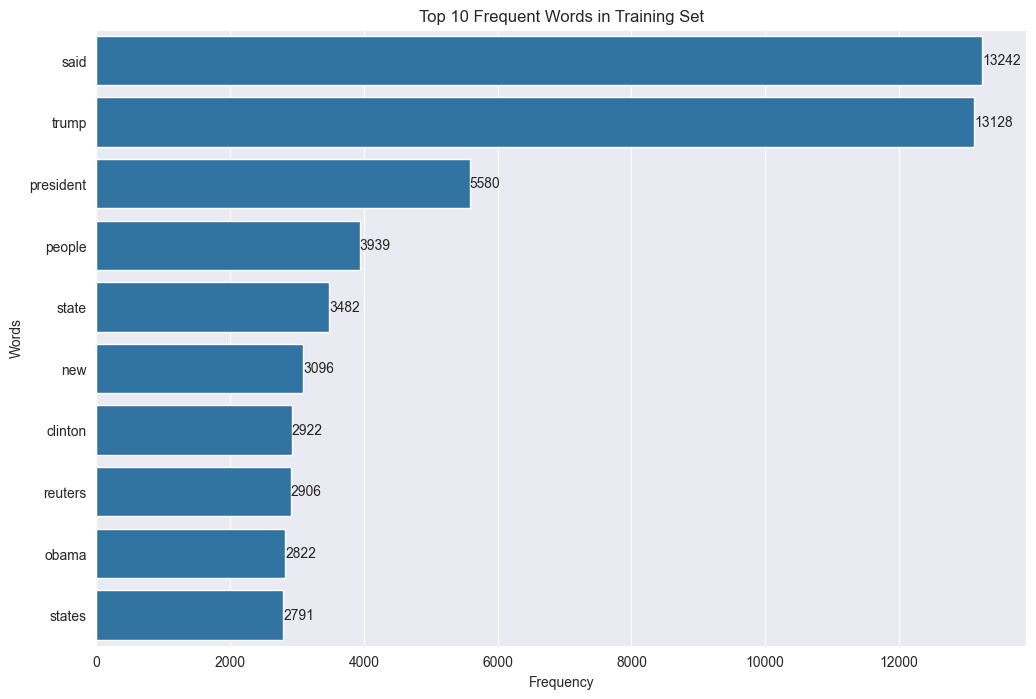

In [78]:
plt.figure(figsize=(12,8))
sns.barplot(x=[item[1] for item in sorted_word_freq[:10]], y=[item[0] for item in sorted_word_freq[:10]])
for index, value in enumerate([item[1] for item in sorted_word_freq[:10]]):
    plt.text(value, index, str(value), va='center')
plt.title('Top 10 Frequent Words in Training Set')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()